In [6]:
from pathlib import Path

import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
from pesq import pesq
from pystoi import stoi
import soundfile as sf
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

In [7]:
torch.manual_seed(777)
np.random.seed(777)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [8]:
def plot_spectrograms(noisy_wav, enhanced_wav, clean_wav, sr=16000, save_path=None):
    """
    Визуализирует спектрограммы noisy, enhanced и clean
    """
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))

    wavs = [noisy_wav, enhanced_wav, clean_wav]
    titles = ["Noisy", "Enhanced", "Clean"]

    for i, (wav, title) in enumerate(zip(wavs, titles)):
        if isinstance(wav, torch.Tensor):
            wav = wav.cpu().numpy()

        D = librosa.stft(wav, n_fft=512, hop_length=128, win_length=512)
        D_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

        img = librosa.display.specshow(
            D_db,
            sr=sr,
            hop_length=128,
            x_axis="time",
            y_axis="hz",
            ax=axes[i],
            cmap="viridis",
        )
        axes[i].set_title(f"{title} Spectrogram", fontsize=14)
        axes[i].set_ylabel("Frequency (Hz)")
        fig.colorbar(img, ax=axes[i], format="%+2.0f dB")

    axes[-1].set_xlabel("Time (s)")
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

def evaluate_test_set(model, test_loader, num_samples=5):
    model.eval()
    
    results = []
    sample_count = 0
    
    enhanced_dir = Path(config.results_path) / "audio_samples"
    enhanced_dir.mkdir(parents=True, exist_ok=True)
    
    print("Evaluating test set with URGENT Challenge metrics...")
    print("="*70)
    
    with torch.no_grad():
        for batch in tqdm(test_loader):
            noisy = batch['noisy'].to(device)
            clean = batch['clean'].to(device)
            filename = batch['filename'][0]
            clean_path = batch['clean_path'][0]
            noisy_path = batch['noisy_path'][0]

            enhanced_wav, _, _, _, _ = model(noisy)

            enhanced_path = enhanced_dir / filename
            torchaudio.save(
                str(enhanced_path),
                enhanced_wav[0].cpu().unsqueeze(0),
                config.sample_rate
            )

            metrics = URGENTMetrics.compute_all_metrics(
                clean_path,
                str(enhanced_path),
                sr=config.sample_rate
            )
            
            results.append({
                'filename': filename,
                **metrics
            })

            if sample_count < num_samples:
                import shutil
                shutil.copy(noisy_path, enhanced_dir / f"{Path(filename).stem}_noisy.wav")
                shutil.copy(clean_path, enhanced_dir / f"{Path(filename).stem}_clean.wav")

                plot_spectrograms(
                    noisy[0].cpu(),
                    enhanced_wav[0].cpu(),
                    clean[0].cpu(),
                    sr=config.sample_rate,
                    save_path=str(enhanced_dir / f"{Path(filename).stem}_spectrogram.png")
                )
                
                sample_count += 1
 
    results_df = pd.DataFrame(results)
    results_df.to_csv(f"{config.results_path}/urgent_test_results.csv", index=False)

    print("\n" + "="*70)
    print("URGENT CHALLENGE METRICS - Test Set Results")
    print("Model: MP-SENet with xLSTM + Mamba (Official Implementations)")
    print("="*70)
    print(f"PESQ:   {results_df['PESQ'].mean():.4f} ± {results_df['PESQ'].std():.4f}  (Target: ≥3.25)")
    print(f"STOI:   {results_df['STOI'].mean():.4f} ± {results_df['STOI'].std():.4f}")
    print(f"eSTOI:  {results_df['eSTOI'].mean():.4f} ± {results_df['eSTOI'].std():.4f}")
    print(f"SI-SDR: {results_df['SI-SDR'].mean():.2f} ± {results_df['SI-SDR'].std():.2f} dB")
    print("="*70)
    print(f"Files passing PESQ ≥ 3.25: {(results_df['PESQ'] >= 3.25).sum()}/{len(results_df)} "
          f"({(results_df['PESQ'] >= 3.25).sum() / len(results_df) * 100:.1f}%)")
    print(f"Best PESQ: {results_df['PESQ'].max():.4f}")
    print(f"Worst PESQ: {results_df['PESQ'].min():.4f}")
    print(f"Median PESQ: {results_df['PESQ'].median():.4f}")
    print("="*70)
    
    return results_df


[5] Evaluating on test set...
Loaded 824 file pairs for train mode
Evaluating test set with URGENT Challenge metrics...


  0%|          | 0/824 [00:00<?, ?it/s]

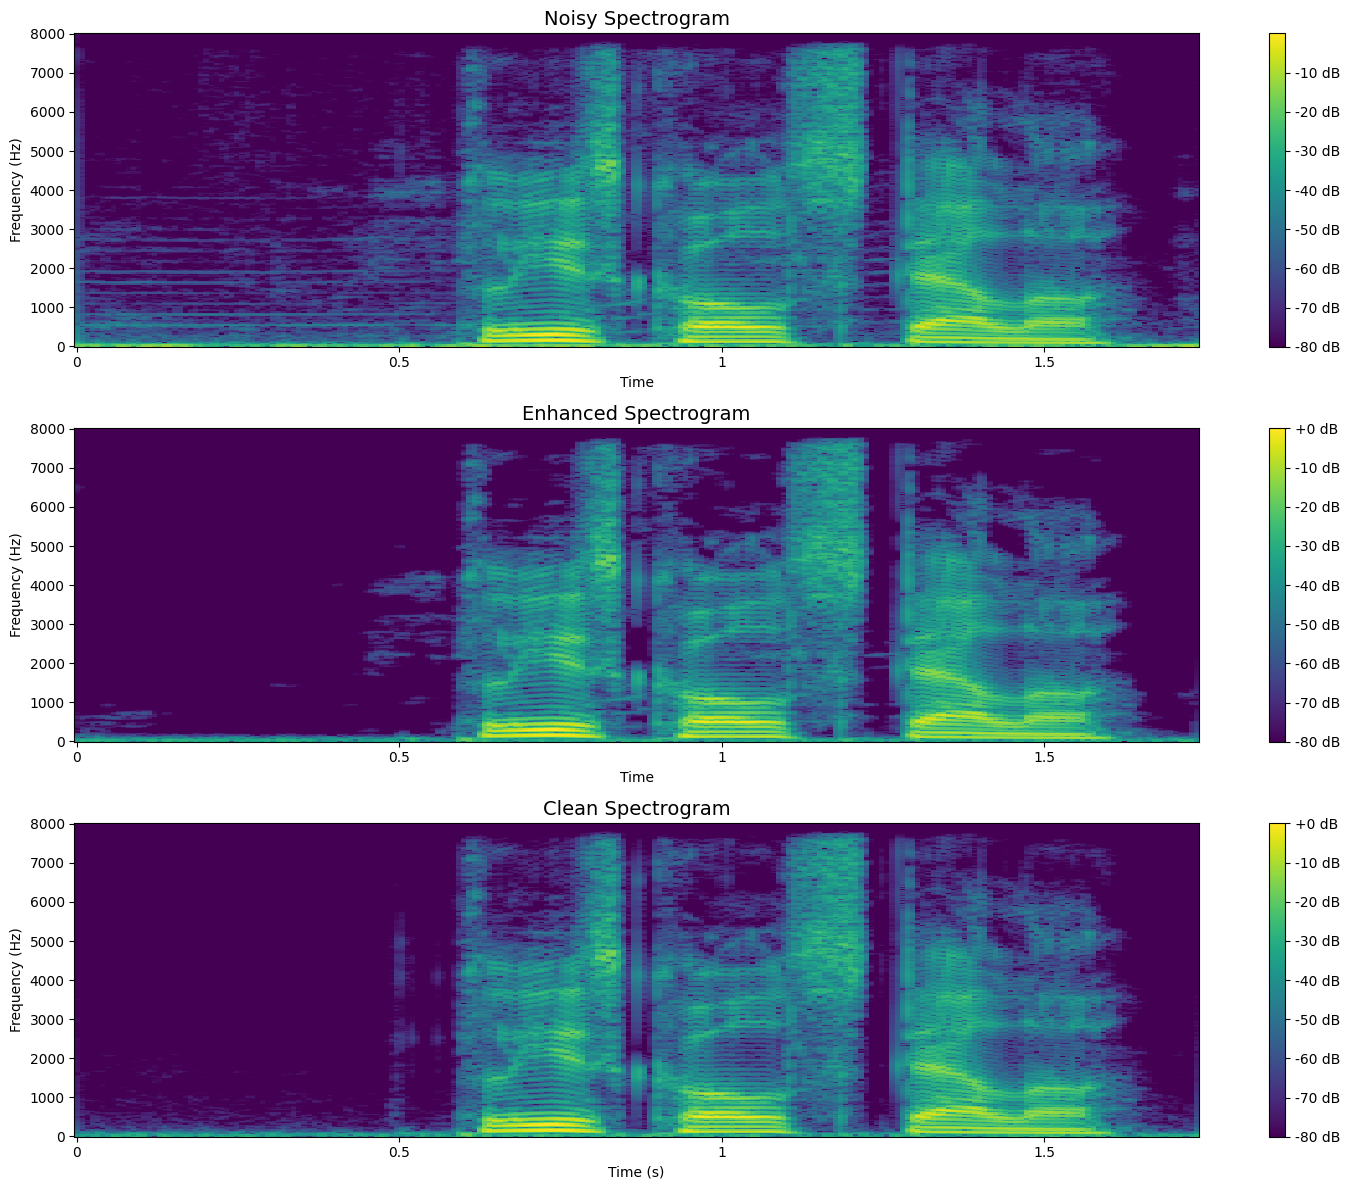

  0%|          | 1/824 [00:04<54:53,  4.00s/it]

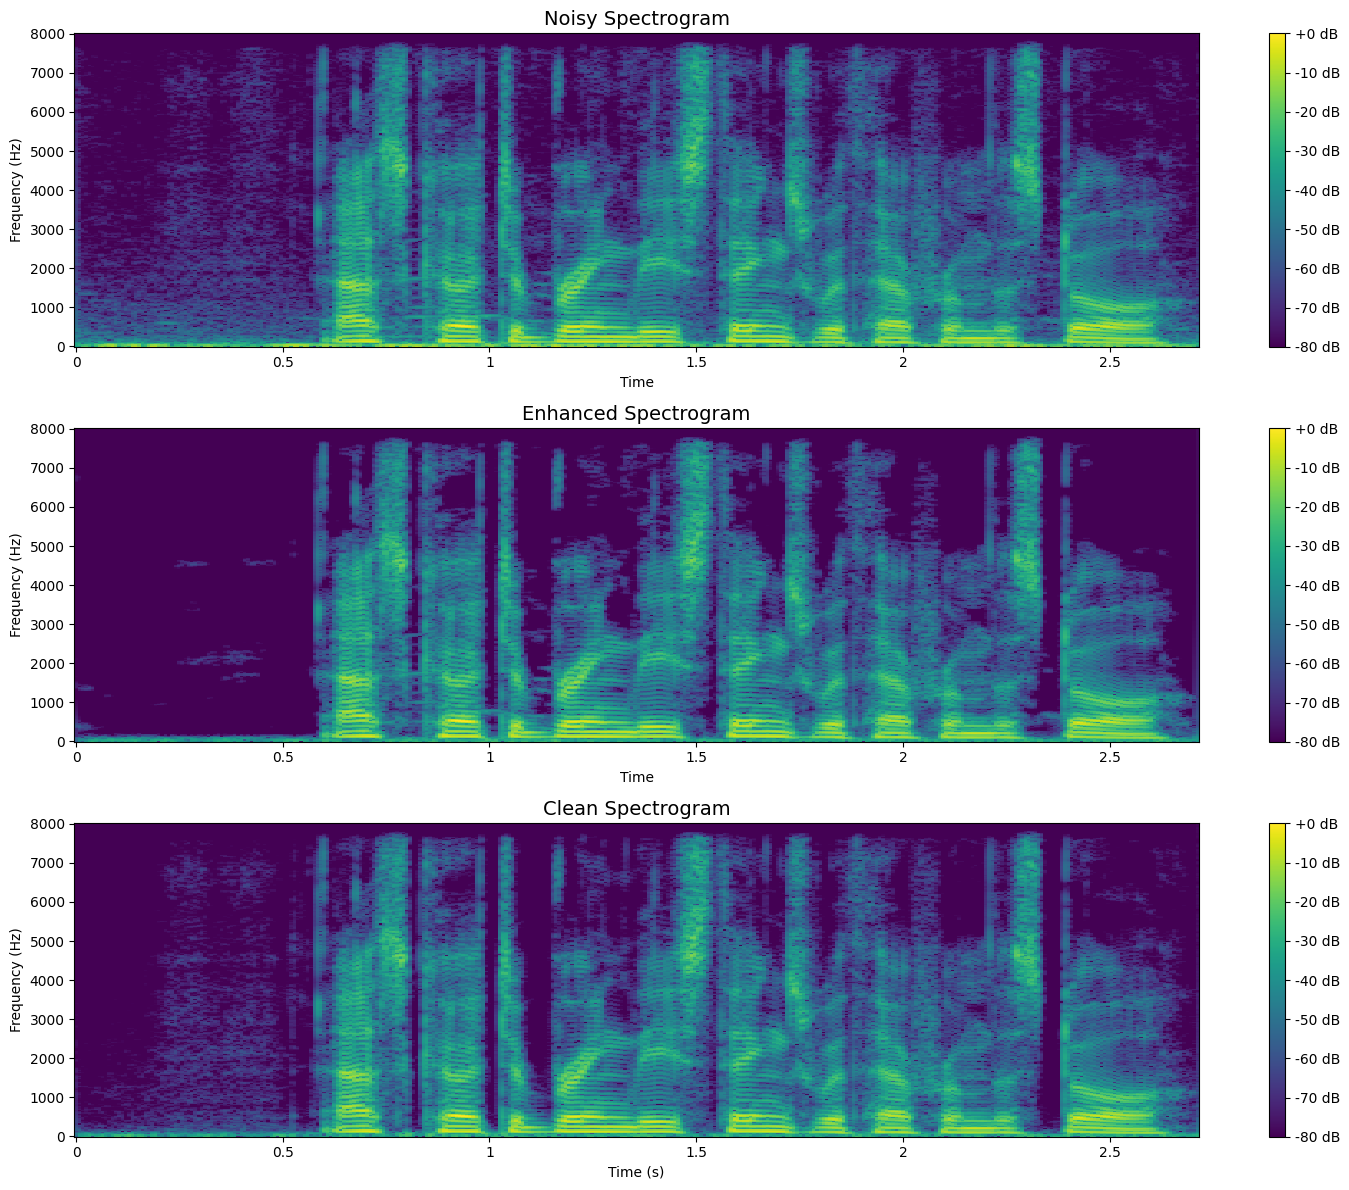

  0%|          | 2/824 [00:06<39:42,  2.90s/it]

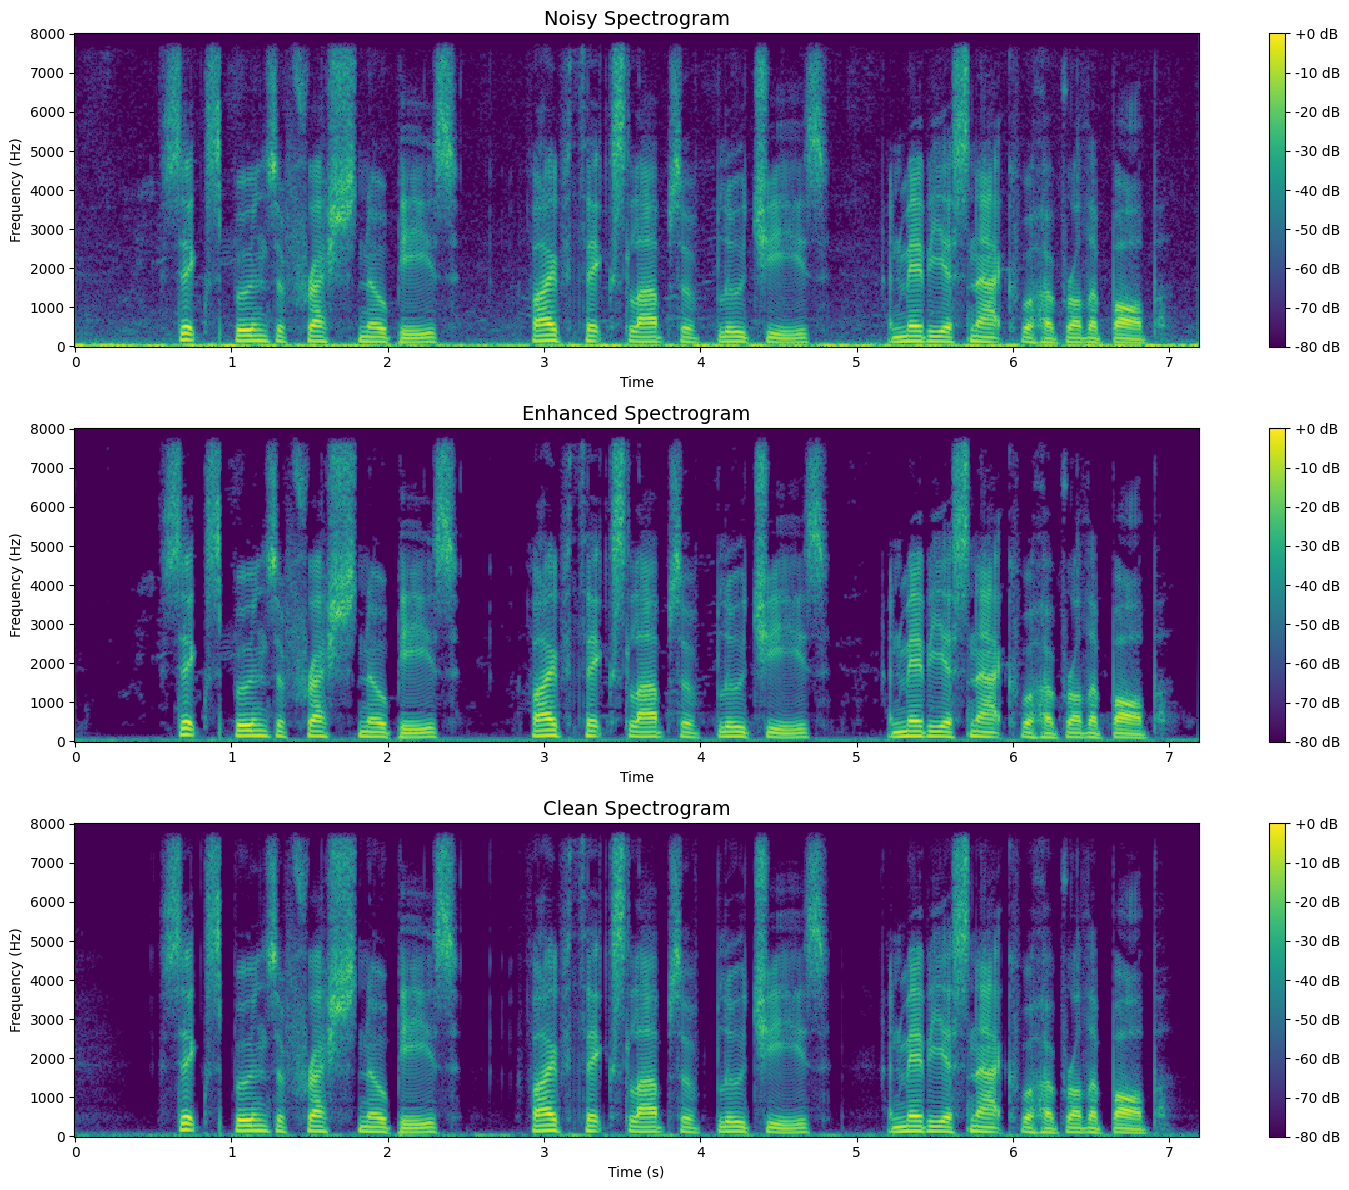

  0%|          | 3/824 [00:09<42:44,  3.12s/it]

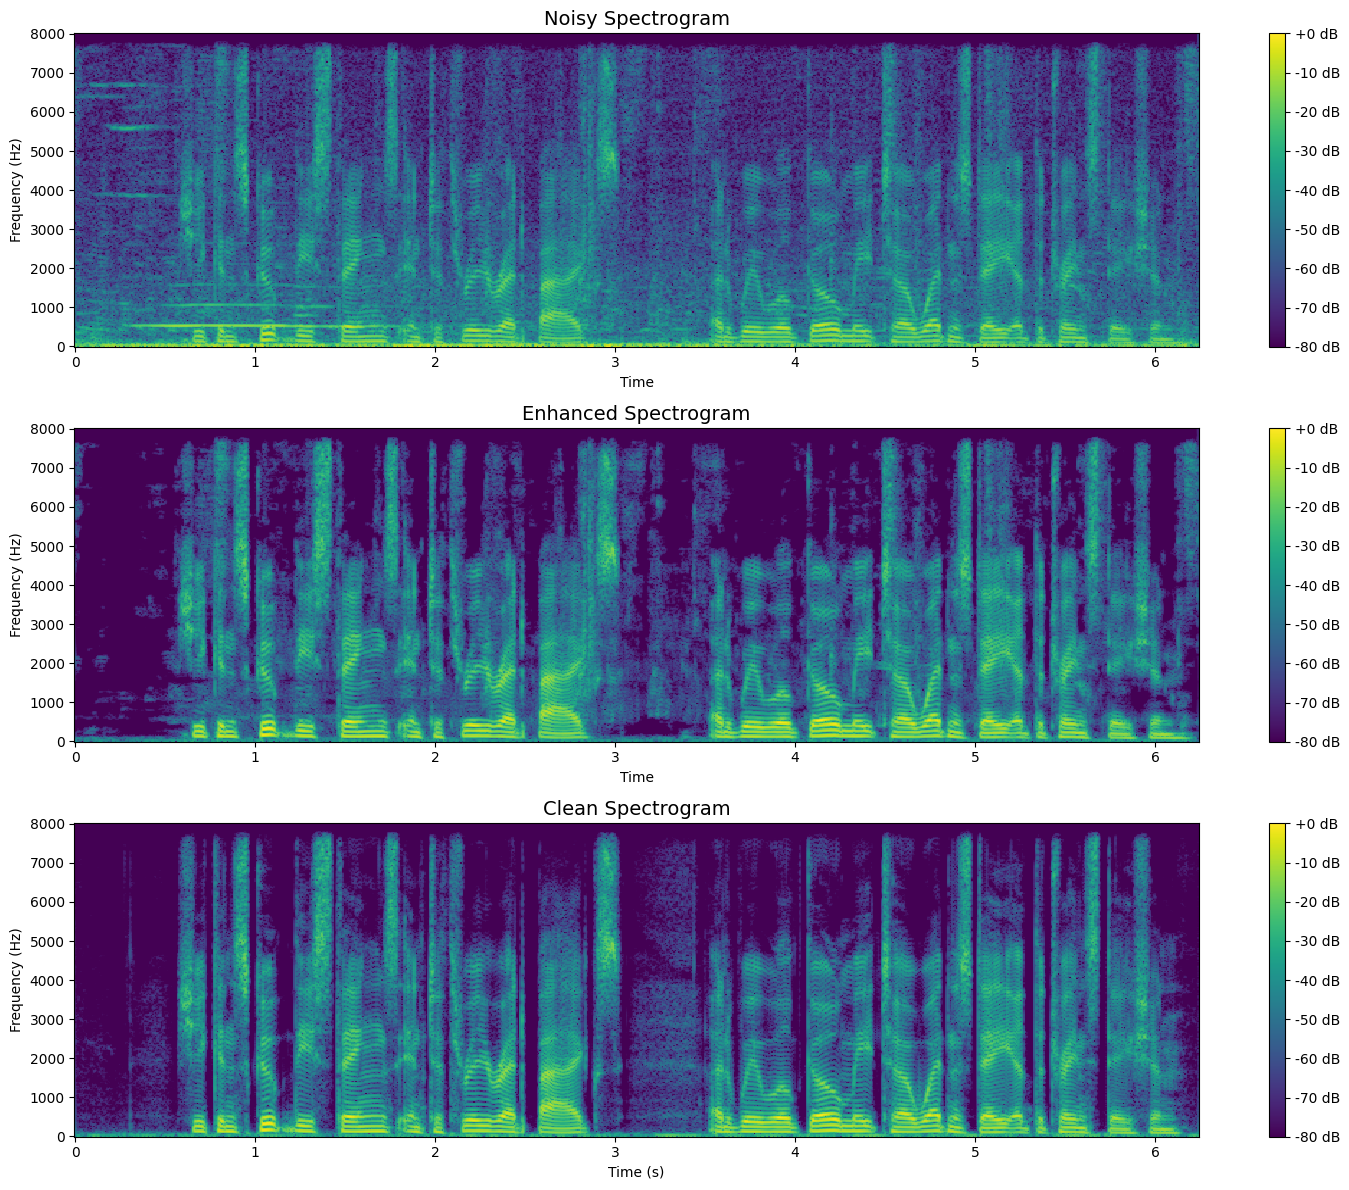

  0%|          | 4/824 [00:12<41:27,  3.03s/it]

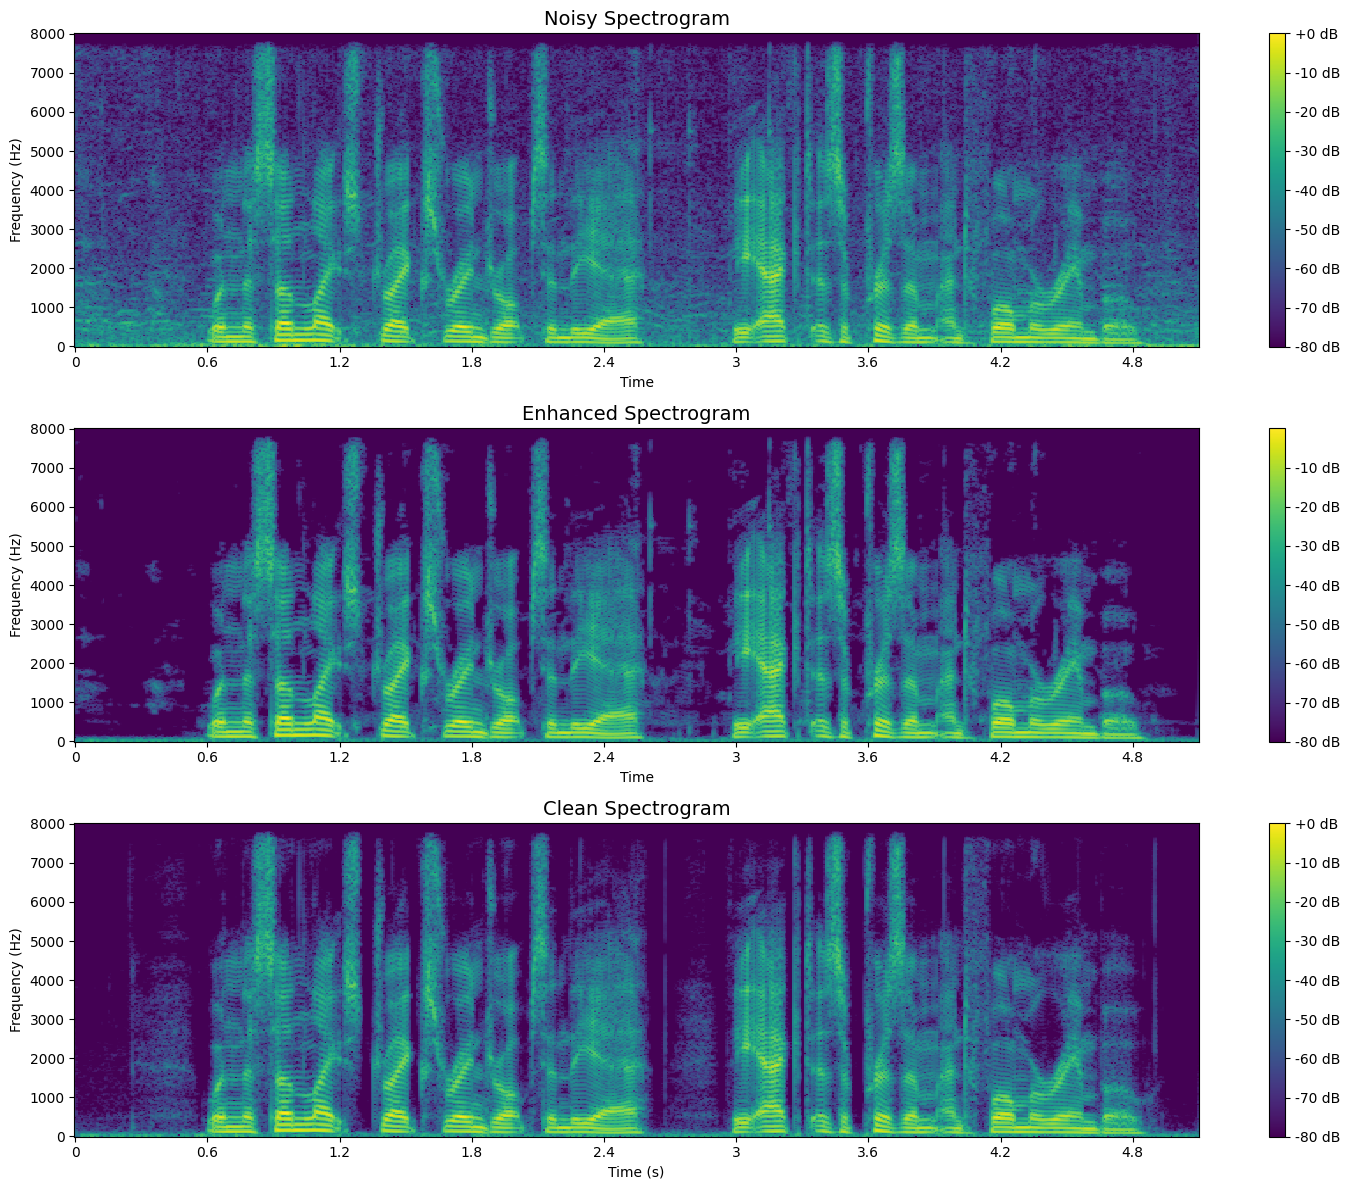

100%|██████████| 824/824 [03:53<00:00,  3.52it/s]


URGENT CHALLENGE METRICS - Test Set Results
Model: MP-SENet with xLSTM + Mamba (Official Implementations)
PESQ:   2.6600 ± 0.7175  (Target: ≥3.25)
STOI:   0.9318 ± 0.0632
eSTOI:  0.8375 ± 0.1186
SI-SDR: 18.82 ± 4.15 dB
Files passing PESQ ≥ 3.25: 198/824 (24.0%)
Best PESQ: 4.3059
Worst PESQ: 1.1309
Median PESQ: 2.6575


In [12]:
from scripts.models import MPSENet
from scripts.utils.create_dataset import VoiceBankDataset
from scripts.utils.compute_metrics import URGENTMetrics
from scripts.config import Config

config = Config()

checkpoint = torch.load("checkpoints/best_model.pt", weights_only=False)
model = MPSENet(config)
model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)

# Оценка на тестовой выборке
print("\n[5] Evaluating on test set...")
test_dataset = VoiceBankDataset(
    config.test_clean_path, config.test_noisy_path, max_len=None
)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
results_df = evaluate_test_set(model, test_loader, num_samples=5)